借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！

In [7]:
from __future__ import print_function

# pip install scikit-learn-intelex

from sklearnex import patch_sklearn

patch_sklearn()
# from attention_utils import get_activations
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from typing import Tuple

import tensorflow as tf
import keras.layers as layers
from keras.models import  models
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from tensorflow.python.lib.io import file_io
from tensorflow.core.example import example_pb2



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print("----- activations -----")
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [
            layer.output for layer in model.layers if layer.name == layer_name
        ]  # all layer outputs
    funcs = [
        K.function([inp] + [K.learning_phase()], [out]) for out in outputs
    ]  # evaluation functions
    layer_outputs = [func([inputs, 1.0])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print("shape为", layer_activations.shape)
            print(layer_activations)
    return activations
def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y
def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y
def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, :, attention_dim] = np.tile(y[:], (1, time_steps))
    return x, y

In [9]:
# keras.layers.Activation('linear')

In [10]:
dfstate = pd.read_csv("./data/states.txt")
dfstate["start"] = dfstate.apply(
    lambda row: row["date"] + " " + row["start_time"], axis=1
)
dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
dfstate["label"] = dfstate.pop("state").str.strip()
# 转为时间类型
dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
# dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
# dfstate['label'] = dfstate.apply(number_to_label,axis=1)
dfstate.to_csv("./data/states.csv")
print(dfstate.head(), dfstate.shape)

         date start_time  end_time               start                 end  \
0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   

  label  
0     装  
1     卸  
2     装  
3     卸  
4     装   (56, 6)


In [11]:
# 定义读取数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果
    inputDF.insert(0, "label", "-")
    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]
        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass
    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF
def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )
# 读取数据
df17 = read_data("./data/data_17.xlsx")
df21 = read_data("./data/data_21.xlsx")
df22 = read_data("./data/data_22.xlsx")
df23 = read_data("./data/data_23.xlsx")

In [14]:
# 假设你有一个Pandas DataFrame
# df = pd.DataFrame({
#     'feature1': [...],  # 假设是一列数值列表
#     'feature2': [...],  # 另一列数值列表
#     'label': [...]      # 假设是一列标签
# })

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def dataframe_to_tfrecord(df, filename):
    writer = tf.io.TFRecordWriter(filename)

    for _, row in df.iterrows():
        feature = {
            'feature1': _float_feature(row['feature1']),
            'feature2': _float_feature(row['feature2']),
            'label': _float_feature(row['label'])
            # 更改此部分以适应你的数据类型和列名
        }

        example = tf.train.Example(features=tf.train.Features(feature=feature))
        serialized_example = example.SerializeToString()

        writer.write(serialized_example)

    writer.close()

# 调用函数将DataFrame写入TFRecords文件
# dataframe_to_tfrecord(df, 'my_data.tfrecords') 



In [15]:
# data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# ax = plt.gca()
# ax.set_xlim(left=0, right=19000)
# # 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN']
# plt.show()

### 改各自层数！

In [49]:
def normalize(
    inpudf: pd.DataFrame,
    numeric_col_names: list[str],
    label_col_names: list[str],
    time_col_names: list[str],
) -> Tuple[pd.DataFrame, MinMaxScaler, LabelEncoder]:
    inpudf = inpudf.copy()
    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象
    scaler = MinMaxScaler(feature_range=(-10, 10))
    scaler.fit(inpudf[numeric_col_names])
    # （label）标准化
    le = LabelEncoder()
    # ["装", "卸",'-']
    le.fit(inpudf[label_col_names])
    # newdata=np.array(inpudf)
    # 数值型数据标准化： 使用StandardScaler或者MinMaxScaler进行标准化处理。
    for col in numeric_col_names:
        inpudf[col] = le.fit_transform(inpudf[col])
    # 类别数据（label）标准化： 类别数据通常不做标准化，而是进行编码，比如One-Hot编码或者Label Encoding。
    for col in label_col_names:
        inpudf[col] = le.fit_transform(inpudf[col])
    # 时间数据标准化： 时间数据通常不进行标准化，而是转换成可以比较的形式，如Unix时间戳或时间段差。
    # 将所有时间列转换为Unix时间戳（单位为秒）
    for col in time_col_names:
        print(inpudf[col].astype(np.int64), inpudf[col].astype(np.int64) / 1e9)
        inpudf[col] = (
            inpudf[col].astype(np.int64) / 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）
    return inpudf, scaler, le
# 反标准化
def denormalize(
    inpudf: pd.DataFrame,
    scaler: MinMaxScaler,
    le: LabelEncoder,
    numeric_col_names: list[str],
    label_col_names: list[str],
    time_col_names: list[str],
) -> pd.DataFrame:
    """对df中的数值列进行反标准化处理"""
    # 数值型数据标准化-
    inpudf[numeric_col_names] = scaler.inverse_transform(inpudf[numeric_col_names])
    # 类别数据（label）标准化-
    for col in label_col_names:
        inpudf[col] = le.inverse_transform(inpudf[col])
    # 时间数据标准化-
    for col in time_col_names:
        inpudf[col] = pd.to_datetime(
            inpudf[col] * 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）
    return inpudf

In [17]:
numeric_col_names = ["原始重量", "稳定重量", "轴重", "wpu_z", "su_z", "速度"]
# delete some
#  "轨迹时间",'原始重量_diff', '稳定重量_diff', '轴重_diff','su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff','估计重量',    'su_x_diff','su_y_diff', 'su_z_diff',  'su_ad', ,'wpu_x', 'wpu_y', 'su_x', 'su_y',

# ['原始重量', '稳定重量', '轴重', 'su_ad',
#                 'wpu_x', 'wpu_y', 'wpu_z',
#                 'su_x', 'su_y', 'su_z',
#                 '原始重量_diff', '稳定重量_diff', '轴重_diff',
#                 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
#                 'su_x_diff', 'su_y_diff', 'su_z_diff',
#                 '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶']
label_col_names = ["label"]
time_col_names = ["时间"]

data = pd.concat([df17, df21], axis=0, ignore_index=True)

print(data.columns)
print(data.shape)

df22 = df22
df23 = df23

Index(['label', '时间', '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z',
       'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff',
       'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff',
       'su_y_diff', 'su_z_diff', '轨迹时间', '速度', '估计重量', '原始重量加速度', '稳定重量加速度',
       '原始重量加速度_二阶', '稳定重量加速度_二阶'],
      dtype='object')
(41494, 29)


In [50]:

data = data[numeric_col_names + label_col_names + time_col_names]  # 去掉无用列
display(data)
# Normalized
data, scaler, le = normalize(data, numeric_col_names, label_col_names, time_col_names)
display(data.shape)
# feature_col_names = numeric_col_names +  time_col_names
feature_col_names = numeric_col_names  # 暂时去掉 时间
X = data[feature_col_names]
Y = data[label_col_names]

x_train, x_test, y_train, y_test = train_test_split(
    np.asarray(X), np.asarray(Y), test_size=0.33, shuffle=False
)

feature_col_num = len(feature_col_names)

# Input image dimensions

# Convert class vectors to binary class matrices. This uses 1 hot encoding.
# y_train_binary = keras.utils.to_categorical(y_train,num_classes)
# y_test_binary = keras.utils.to_categorical(y_test,num_classes)

x_train = x_train.reshape(-1, feature_col_num)
x_test = x_test.reshape(-1, feature_col_num)

display(y_train.shape, y_test.shape)
y_train = y_train.reshape(
    -1,
)
y_test = y_test.reshape(
    -1,
)
display(y_train.shape, y_test.shape)

,原始重量,稳定重量,轴重,wpu_z,su_z,速度,label,时间
0,2115,1,1240,2542,1384,0,0,1.000000e-09
1,2099,1,1241,2569,1384,0,0,1.000000e-09
2,2032,1,1230,2556,1385,0,0,1.000000e-09
3,2074,1,1238,2556,1386,0,0,1.000000e-09
4,2055,1,1231,2557,1384,0,0,1.000000e-09
...,...,...,...,...,...,...,...,...
41489,543,0,475,3963,1171,0,0,1.000000e-09
41490,536,0,472,3949,1171,0,0,1.000000e-09
41491,498,0,467,3959,1168,0,0,1.000000e-09
41492,521,0,465,3958,1170,0,0,1.000000e-09


0        0
1        0
2        0
3        0
4        0
        ..
41489    0
41490    0
41491    0
41492    0
41493    0
Name: 时间, Length: 41494, dtype: int64 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41489    0.0
41490    0.0
41491    0.0
41492    0.0
41493    0.0
Name: 时间, Length: 41494, dtype: float64


c:\ScriptsApplications\.devhome\conda\envs\py310_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(41494, 8)

(27800, 1)

(13694, 1)

(27800,)

(13694,)

In [51]:

SINGLE_ATTENTION_VECTOR = False





def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    # a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = layers.Dense(input_dim, activation="softmax")(a)
    if SINGLE_ATTENTION_VECTOR:
        a = layers.Lambda(lambda x: K.mean(x, axis=1), name="dim_reduction")(a)
        a = layers.RepeatVector(input_dim)(a)
    a_probs = layers.Permute((1, 2), name="attention_vec")(a)



    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = layers.Multiply()([inputs, a_probs])
    return output_attention_mul





# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = layers.Permute((2, 1))(inputs)
    a = layers.Dense(time_steps, activation="softmax")(a)
    if single_attention_vector:
        a = layers.Lambda(lambda x: K.mean(x, axis=1))(a)
        a = layers.RepeatVector(input_dim)(a)



    a_probs = layers.Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = layers.Multiply()([inputs, a_probs])
    return output_attention_mul





def create_dataset(dataset: pd.DataFrame, look_back: int):
    """
    Processing the data
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset.iloc[i : (i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)



    return TrainX, Train_Y





def attention_model(TIME_STEPS=5,INPUT_DIMS=1)-> models.Model:
    drop, lstm_units=0.25,32
    # inputs = Input(((data.shape[1],1)))
    inputs = tf.keras.layers.Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = layers.Conv1D(
        filters=64, kernel_size=32, dilation_rate=2, padding="same", activation="relu"
    )(inputs)
    # x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = layers.Dropout(drop)(x)

    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    # For GPU you can use CuDNNLSTM
    lstm_out = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, name="bilstm")
    )(x)
    lstm_out = layers.Dropout(drop)(lstm_out)

    # attention_mul = attention_3d_block(lstm_out)
    attention_mul = layers.Flatten()(lstm_out)

    # output = Dense(1, activation='sigmoid')(attention_mul)
    output = layers.Dense(1, activation="linear")(attention_mul)
    model = models.Model(inputs=[inputs], outputs=output)
    return model

In [20]:
# 假设这是您的DataFrame
df = pd.DataFrame(
    {
        "A": [1, 2, 3],
        "B": [4.5, 5.5, 6.5],
        "C": ["foo", "bar", "baz"],
        "D": [True, False, True],
    }
)
# 使用apply方法和to_numeric函数选择数值类型的列
numeric_columns = df.apply(pd.to_numeric, errors="coerce").columns
# 打印结果
print(numeric_columns)
# numeric_columns_clean = numeric_columns[numeric_columns.apply(pd.to_numeric).notna()]

Index(['A', 'B', 'C', 'D'], dtype='object')


In [21]:
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")



print(gpus)



# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

2.15.0
[]
Available GPU devices: []


In [52]:

batch_size = feature_col_num * 1
epochs = 10
drop = 0.2



# model = models.Sequential(
#     [
#         tf.keras.layers.Input(
#             batch_input_shape=(
#                 None,
#                 feature_col_num,
#             ),
#             batch_size=batch_size,
#             name="input",
#         ),
#         layers.Dense(units=5),
#         # layers.Conv1D(5, (3), activation=tf.nn.relu),
#         # layers.MaxPooling1D(pool_size=2),
#         layers.Dropout(drop),
#         layers.Flatten(),
#         # layers.Dense(units=8, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#         layers.Dense(
#             units=4,
#             activation=tf.nn.relu,
#             kernel_regularizer=tf.keras.regularizers.l2(0.001),
#         ),
#         layers.Dense(units=1, activation="linear"),
#     ]
# ) 
model =attention_model(feature_col_num)

model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer="sgd",
    metrics=["accuracy"],
)
# model.build()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 6, 64)             2112      
                                                                 
 dropout_9 (Dropout)         (None, 6, 64)             0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 6, 64)             24832     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 6, 64)             0         
                                                                 
 flatten_6 (Flatten)         (None, 384)               0         
                                                           

In [53]:
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [54]:
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[tf_callback],
)

Epoch 1/10
4634/4634 [==============================] - 30s 6ms/step - loss: 0.0754 - accuracy: 0.9741 - val_loss: 0.0659 - val_accuracy: 0.9752
Epoch 2/10
4634/4634 [==============================] - 27s 6ms/step - loss: 0.0644 - accuracy: 0.9798 - val_loss: 0.0616 - val_accuracy: 0.9752
Epoch 3/10
4634/4634 [==============================] - 26s 6ms/step - loss: 0.0631 - accuracy: 0.9797 - val_loss: 0.0601 - val_accuracy: 0.9752
Epoch 4/10
4634/4634 [==============================] - 26s 6ms/step - loss: 0.0643 - accuracy: 0.9796 - val_loss: 0.1251 - val_accuracy: 0.9752
Epoch 5/10
4634/4634 [==============================] - 27s 6ms/step - loss: 0.0640 - accuracy: 0.9793 - val_loss: 0.0618 - val_accuracy: 0.9752
Epoch 6/10
4634/4634 [==============================] - 26s 6ms/step - loss: 0.0628 - accuracy: 0.9796 - val_loss: 0.0593 - val_accuracy: 0.9752
Epoch 7/10
4634/4634 [==============================] - 26s 6ms/step - loss: 0.0616 - accuracy: 0.9800 - val_loss: 0.0631 - val_ac

In [25]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程

In [26]:
model.save("./C_L_A.h5")

c:\ScriptsApplications\.devhome\conda\envs\py310_tf26\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
data22, scaler22, le22 = normalize(
    df22, numeric_col_names, label_col_names, time_col_names
)







X22 = data22[feature_col_names]



Y22 = data22[label_col_names]







x_train22, y_train22 = np.asarray(X22), np.asarray(Y22)







x_train = x_train22.reshape(-1, feature_col_num)





# display(y_train22.shape )



# y_train22 = y_train22.reshape(-1, )







predY = model.predict(x_train, batch_size=batch_size)



# predY=predY.reshape(-1, )





print("y_train22.shape", y_train22.shape)
print("predY.shape", predY.shape)

c:\ScriptsApplications\.devhome\conda\envs\py310_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0        1703203280000000000
1        1703203283000000000
2        1703203285000000000
3        1703203288000000000
4        1703203291000000000
                ...         
27908    1703289599000000000
27909    1703289602000000000
27910    1703289605000000000
27911    1703289608000000000
27912    1703289611000000000
Name: 时间, Length: 27913, dtype: int64 0        1.703203e+09
1        1.703203e+09
2        1.703203e+09
3        1.703203e+09
4        1.703203e+09
             ...     
27908    1.703290e+09
27909    1.703290e+09
27910    1.703290e+09
27911    1.703290e+09
27912    1.703290e+09
Name: 时间, Length: 27913, dtype: float64
4653/4653 [==============================] - 5s 985us/step
y_train22.shape (27913, 1)
predY.shape (27913, 1)


array([    0,     1,     2, ..., 27910, 27911, 27912], dtype=int64)

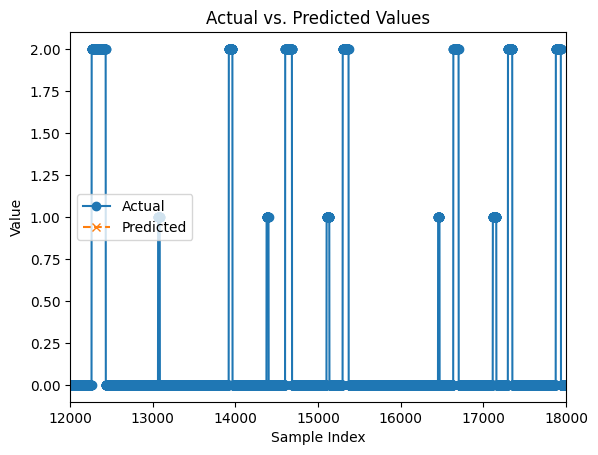

In [28]:
# data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# ax = plt.gca()
# ax.set_xlim(left=0, right=19000)



# # 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN']



# plt.show()
times = df22[time_col_names].index.to_numpy()
display(times)
plt.plot(times, y_train22, label="Actual", marker="o")
plt.plot(times, predY, label="Predicted", linestyle="--", marker="x")



ax = plt.gca()
ax.set_xlim(left=12000, right=18000)
# 添加标题和标签
plt.title("Actual vs. Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")



# 添加图例
plt.legend()



# 显示图形
plt.show()

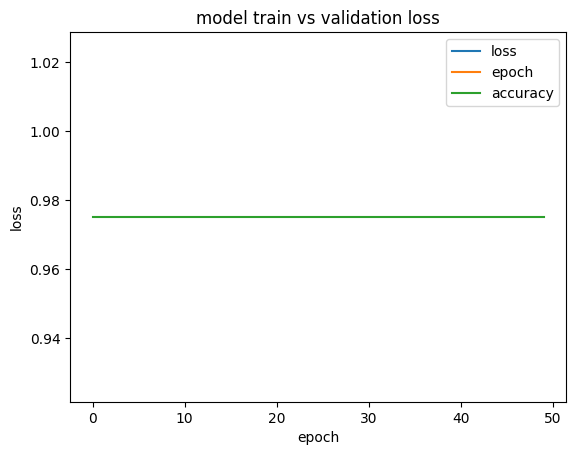

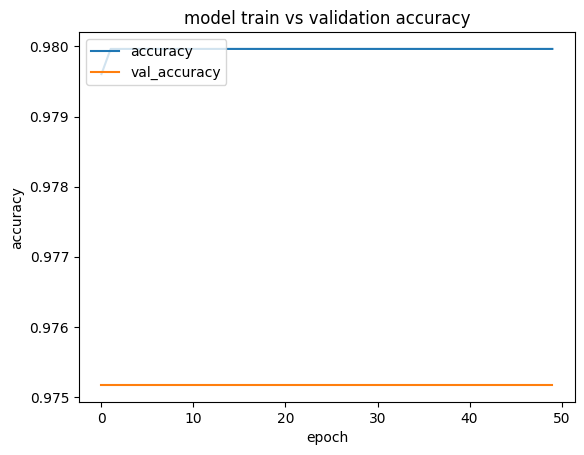

In [29]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [30]:
display(df22.columns)

Index(['label', '时间', '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z',
       'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff',
       'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff',
       'su_y_diff', 'su_z_diff', '轨迹时间', '速度', '估计重量'],
      dtype='object')

In [31]:
df22, scaler22, le22 = normalize(
    df22, numeric_col_names, label_col_names, time_col_names
)

df23, scaler23, le23 = normalize(
    df23, numeric_col_names, label_col_names, time_col_names
)

x_df22 = df22[numeric_col_names]

y_df22 = df22["label"]

y_df22 = np.asfarray(y_df22)

x_df22 = np.asfarray(x_df22)

x_df22 = x_df22.reshape(len(x_df22), feature_col_num, 1)

results22 = model.predict(x_df22)

display(results22)

0        1703203280000000000
1        1703203283000000000
2        1703203285000000000
3        1703203288000000000
4        1703203291000000000
                ...         
27908    1703289599000000000
27909    1703289602000000000
27910    1703289605000000000
27911    1703289608000000000
27912    1703289611000000000
Name: 时间, Length: 27913, dtype: int64 0        1.703203e+09
1        1.703203e+09
2        1.703203e+09
3        1.703203e+09
4        1.703203e+09
             ...     
27908    1.703290e+09
27909    1.703290e+09
27910    1.703290e+09
27911    1.703290e+09
27912    1.703290e+09
Name: 时间, Length: 27913, dtype: float64
0        1703289614000000000
1        1703289617000000000
2        1703289620000000000
3        1703289623000000000
4        1703289626000000000
                ...         
27937    1703375985000000000
27938    1703375989000000000
27939    1703375992000000000
27940    1703375995000000000
27941    1703375998000000000
Name: 时间, Length: 27942, dtype: int64 0   

c:\ScriptsApplications\.devhome\conda\envs\py310_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ScriptsApplications\.devhome\conda\envs\py310_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


873/873 [==============================] - 1s 1ms/step


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

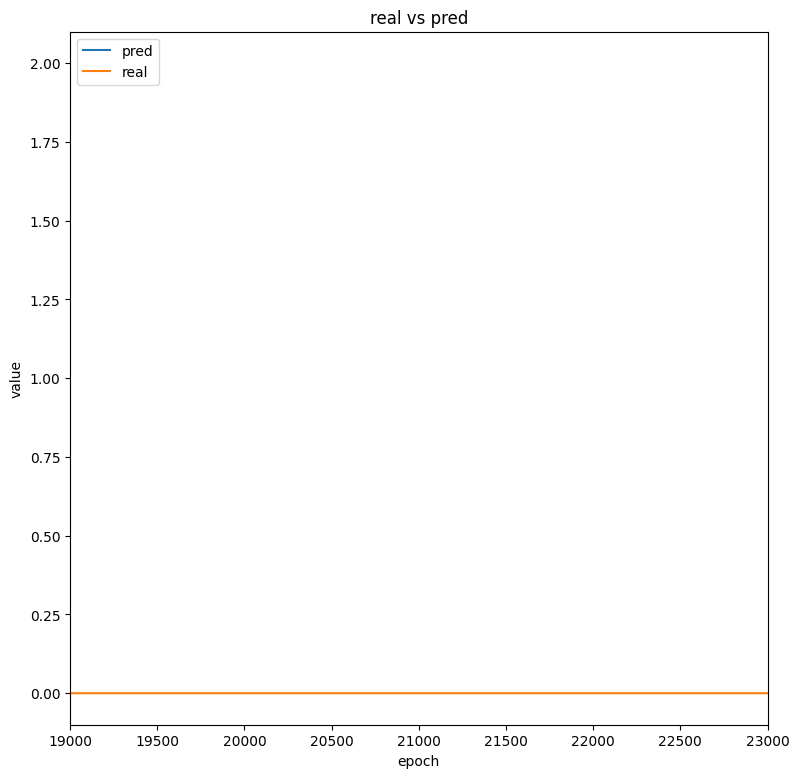

In [32]:
fig_acc = plt.figure(figsize=(9, 9))
plt.plot(results22[0:27000])
plt.plot(y_df22[0:27000])
plt.title("real vs pred")
plt.ylabel("value")
plt.xlabel("epoch")
plt.xlim((19000, 23000))
plt.legend(["pred", "real"], loc="upper left")
plt.show()